In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt
import pandas_datareader as pdr
plt.style.use('fivethirtyeight')

In [2]:
#day stuff
today = date.today()
year = today.year
month = today.month
day = today.day

In [3]:
def ema(closePrices, period, smoothing = 2):
    #returns last ema and current ema
    
    ema = [sum(closePrices[-period:]) / period]
    
    for price in closePrices[-period:]:
        ema.append((price * (smoothing / (1 + period))) + ema[-1] * (1 - (smoothing / (1 + period))))
        
    return ema[-2], ema[-1]

In [4]:
def getdata(ticker, start = datetime.datetime(year - 1, month, day), end = datetime.datetime(year, month, day)):
    output = pdr.get_data_yahoo(ticker,start, end)
    dates =[]
    for x in range(len(output)):
        newdate = str(output.index[x])
        newdate = newdate[0:10]
        dates.append(newdate)

    output['Date'] = dates
    dateValue = []
    for x in range(len(output)):
        dateValue.append(x)
    output['Date Value'] = dateValue
    return output

In [5]:
def currEMA(closePrices, period, smoothing = 2):
    #returns current EMA
    
    ema = [sum(closePrices[-period:]) / period]
    
    for price in closePrices[-period:]:
        ema.append((price * (smoothing / (1 + period))) + ema[-1] * (1 - (smoothing / (1 + period))))
        
    return ema[-1]

In [6]:
#set Variables
enteredTrade = False
fastPeriod = 2
slowPeriod = 10
stopLoss = 0.1

In [8]:
def arrayEMA(closePrices, period):
    #returns array of EMAs
    tempclosedata = []
    emaArr = []
    for i in range(period):
        tempclosedata.append(closePrices[i])
        emaArr.append(None)
    for i in range(period, len(closePrices)):
        emaArr.append(currEMA(tempclosedata, period))
        tempclosedata.append(closePrices[i])
    return emaArr

In [9]:
#EMA Arrays
slowEMA = arrayEMA(closedata, slowPeriod)
fastEMA = arrayEMA(closedata, fastPeriod)

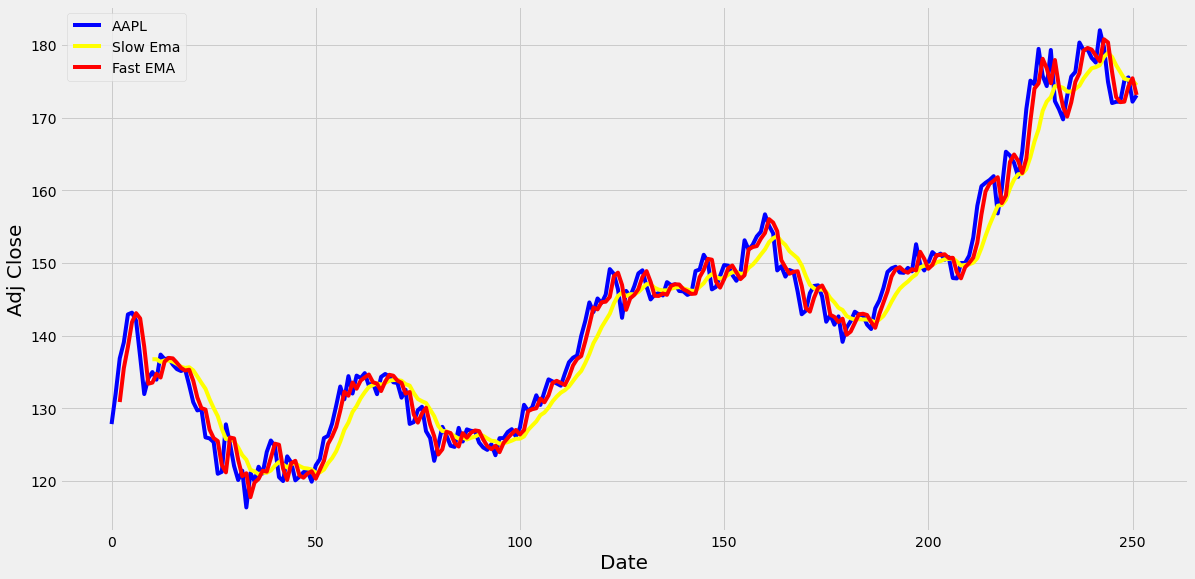

In [10]:
#Plots the fast and slow EMAs with the real Close Prices per day over 1 year
plt.figure(figsize = (18,9))
plt.plot(closedata, label = "AAPL", color = "blue")
plt.plot(slowEMA, label = 'Slow Ema', color = 'yellow')
plt.plot(fastEMA, label = 'Fast EMA', color = 'red')
plt.xlabel("Date", fontsize = 20)
plt.ylabel("Adj Close", fontsize = 20)
plt.legend(loc = "upper left")
plt.show()

In [11]:
def buy_sell(closePrices, slowEMA = slowEMA, fastEMA = fastEMA):
    sigBuy = []
    sigSell = []
    data = []
    
    buyPrice = -1
    priceDiff = 0
    stopLoss = 1
    enteredTrade = False 
    madeTotal = 0
    numTrades = 0
    
    #Calculate Support and Resistance
    currentIndex = 0
    currentSupport = 0
    currentResistance = 0
    
    for i in range(len(closePrices)):
        if (currentIndex >= (slowPeriod - 1)):
            currentSupport = 0
            currentResistance = 0
        if(closePrices[i]) < currentSupport or currentSupport == 0:
            currentSupport = closePrices[i]
        if(closePrices[i] > currentResistance):
            currentResistance = closePrices[i]
        data.append(closePrices[i])
        currentIndex += 1
        if (len(closePrices) > (slowPeriod)):
            #Calculate EMAs
            lastEMASlow, presEMASlow = ema(data, slowPeriod)
            lastEMAFast, presEMAFast = ema(data, fastPeriod)
            if buyPrice != -1:
                priceDiff = closePrices[i] - buyPrice
        
            #stoploss if stock dips under the stop loss, sell
            if priceDiff < -stopLoss and enteredTrade == True:
                sigSell.append(closePrices[i])
                sigBuy.append(np.nan)
                enteredTrade = False
                madeTotal = madeTotal + priceDiff
                numTrades = numTrades + 1
            
            #If fast EMA crosses above slow EMA Buys and sets stop loss to be 10% of that value
            elif lastEMASlow > lastEMAFast and presEMASlow < presEMAFast and closePrices[i] <= currentSupport and not enteredTrade:
                buyPrice = closePrices[i]
                stopLoss = buyPrice * .1
                sigBuy.append(closePrices[i])
                sigSell.append(np.nan)
                enteredTrade = True
                numTrades = numTrades + 1
            
            #If fast EMA crosses below slow EMA Sell
            elif lastEMASlow < lastEMAFast and presEMASlow > presEMAFast and closePrices[i] >= currentResistance and currentResistance > 0 and enteredTrade:
                sigSell.append(closePrices[i])
                sigBuy.append(np.nan)
                enteredTrade = False
                madeTotal = madeTotal + priceDiff
                numTrades = numTrades + 1
                
            else:
                sigSell.append(np.nan)
                sigBuy.append(np.nan)
    return sigBuy, sigSell, madeTotal, numTrades

In [12]:
sigBuy, sigSell, made, numTrades = buy_sell(closedata)
print('Amount Made: ')
print(made)
print('Number of Trades: ')
print(numTrades)

Amount Made: 
43.339988708496094
Number of Trades: 
16


In [13]:
x = []
for i in range(len(closedata)):
    x.append(i)

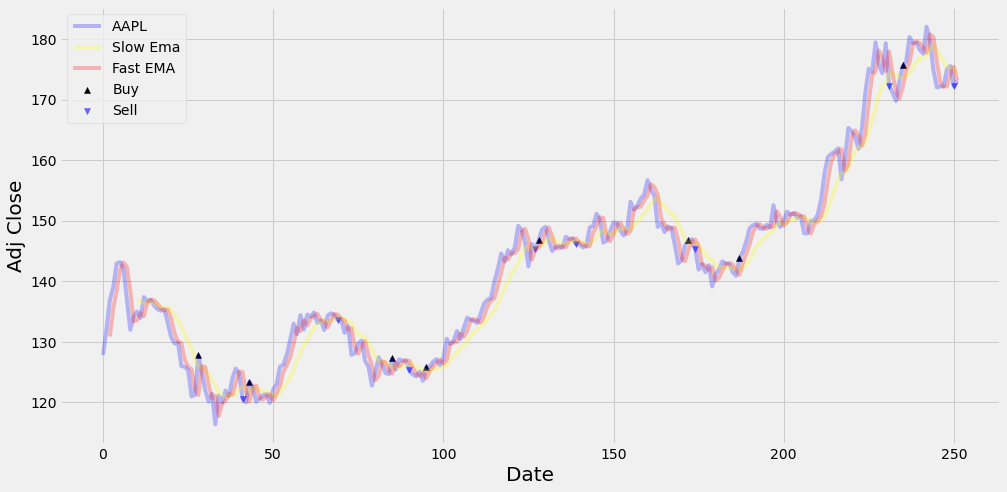

In [14]:
#Plots the fast and slow EMAs with the real Close Prices per day over 1 year
plt.figure(figsize = (15,7.5))
plt.plot(closedata, label = "AAPL", color = "blue", alpha = 0.25)
plt.plot(slowEMA, label = 'Slow Ema', color = 'yellow', alpha = 0.25)
plt.plot(fastEMA, label = 'Fast EMA', color = 'red', alpha = 0.25)
plt.scatter(x, sigBuy, label = 'Buy', marker = '^', color = 'black')
plt.scatter(x, sigSell, label = 'Sell', marker = 'v', color = 'blue', alpha = 0.55)
plt.xlabel("Date", fontsize = 20)
plt.ylabel("Adj Close", fontsize = 20)
plt.legend(loc = "upper left")
plt.show()